## 0. _CreditScoring.csv_

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

### _0.1_ 

CreditScoring.csv [data dictionary](https://github.com/gastonstat/CreditScoring/blob/master/README.md).

In [2]:
scoring_df = pd.read_csv('CreditScoring.csv')
scoring_df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [3]:
scoring_df.shape

(4455, 14)

In [4]:
scoring_df.get_dtype_counts()

int64    14
dtype: int64

In [5]:
scoring_df.isnull().sum()

Status       0
Seniority    0
Home         0
Time         0
Age          0
Marital      0
Records      0
Job          0
Expenses     0
Income       0
Assets       0
Debt         0
Amount       0
Price        0
dtype: int64

In [6]:
scoring_df['Status'].value_counts()

1    3200
2    1254
0       1
Name: Status, dtype: int64

_Статус "**0**" в единичном экземпляре игнорируем_.

In [7]:
scoring_df = scoring_df[scoring_df['Status'] != 0]
len(scoring_df)

4454

In [8]:
# соотношение классов в выборке
scoring_df['Status'].value_counts(normalize=True) * 100

1    71.845532
2    28.154468
Name: Status, dtype: float64

### _0.2_

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [11]:
X, y = scoring_df.drop('Status', 1), scoring_df['Status']

X_norm = X.copy()

for col in X.columns:
    X_norm[col] = StandardScaler().fit_transform(X[[col]])

print(X_norm.shape, y.shape)

(4454, 13) (4454,)


### _0.3 PCA on the full dataset_ 

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

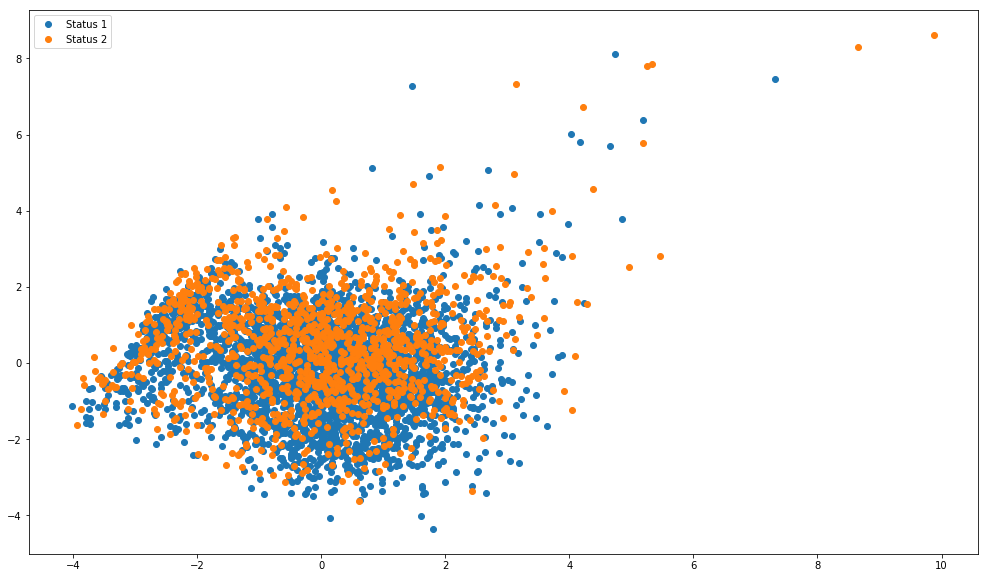

In [13]:
plt.figure(figsize=(17,10))

for u in sorted(y.unique()):
    ix = np.argwhere(y == u).squeeze()
    plt.plot(X_pca[ix, 0], X_pca[ix, 1], 'o', label='Status {}'.format(u))

plt.legend();

In [14]:
for i, component in enumerate(pca.components_):
    print("Component #{}: {:.2f}% of initial variance".format(i + 1, 100 * pca.explained_variance_ratio_[i], 2))

Component #1: 16.51% of initial variance
Component #2: 14.39% of initial variance


_Как можно видеть, по двум компонентам классы плохо разделимы_.

## 1. _HyperParams_ 

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [16]:
X_pca_train, X_pca_test, X_norm_train, X_norm_test, X_train, X_test, y_train, y_test = \
    train_test_split(X_pca, X_norm, X, y, train_size=0.8, random_state=39)

print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)

(3563, 13) (3563,)
(891, 13) (891,)


_Будем считать Status(**2**) positive классом (ведь, скорее всего, именно его мы и хотим предсказывать)_.

In [17]:
%%time

tree = DecisionTreeClassifier(random_state=40)

tree_grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 10)),
    'max_features': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_leaf': list(range(3, 20))
}

f1_scorer = make_scorer(f1_score, pos_label=2, average='binary')

gs_tree = GridSearchCV(tree, tree_grid_params, scoring=f1_scorer, cv=5, n_jobs=4)
gs_tree.fit(X_train, y_train)

best_tree = gs_tree.best_estimator_

Wall time: 44.3 s


In [18]:
best_tree_params = best_tree.get_params()

best_tree_params

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 40,
 'splitter': 'best'}

## 2. _Quality metrics_ 

Поскольку классы в выборке не сбалансированы (~ 70/30%), то имеет смысл использовать метрики Precision / Recall, или даже лучше сразу F1-меру. Причём, мне кажется, что, в данном случае, как раз по указанной причине, правильнее либо взвешивать F1 по числу объектов каждого класса и брать среднее (`scoring='f1_weighted'`), либо вообще оптимизировать под предсказание для _меньшего_ класса _Status(**2**)_, потому что, скорее всего, именно он нам наиболее интересен (собственно, выше я так и сделал).

Другие метрики для интереса тоже посмотрим.

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [20]:
y_tree_pred = best_tree.predict(X_test)

In [21]:
def print_scores(clf_name, best_f1_train_score, y_test, y_pred):
    print('[{}] F1 score best (train): {:.5f}'.format(clf_name, best_f1_train_score))
    print('[{}] F1 score for best (test): {:.5f}'.format(
        clf_name, f1_score(y_test, y_pred, pos_label=2, average='binary')))
    print()

    print( classification_report(y_test, y_pred) )
    print('*' * 60)
    print()

    print('[{}] accuracy (test): {:.5f}'.format(clf_name, accuracy_score(y_test, y_pred)))
    print('*' * 40)
    print()

    print('[{}] R2 (test): {:.5f}'.format(clf_name, r2_score(y_test, y_pred)))
    print('*' * 40)

In [22]:
print_scores('Decision tree', gs_tree.best_score_, y_test, y_tree_pred)

[Decision tree] F1 score best (train): 0.54214
[Decision tree] F1 score for best (test): 0.54167

             precision    recall  f1-score   support

          1       0.79      0.87      0.83       620
          2       0.62      0.48      0.54       271

avg / total       0.74      0.75      0.74       891

************************************************************

[Decision tree] accuracy (test): 0.75309
****************************************

[Decision tree] R2 (test): -0.16665
****************************************


### *2.1 ROC\_AUC, PR\_AUC* 

In [23]:
y_tree_probs = best_tree.predict_proba(X_test)

In [24]:
pd.DataFrame(list(zip(y_tree_probs[:, 0], y_tree_probs[:, 1])), columns=['p1', 'p2'], index=y_tree_pred).head(8)

,p1,p2
1,0.860465,0.139535
2,0.347826,0.652174
1,0.560000,0.440000
1,0.997409,0.002591
1,1.000000,0.000000
1,0.695652,0.304348
2,0.060606,0.939394
2,0.363636,0.636364


In [25]:
def plot_curve_xy(x, y, class_label):    
    plt.plot(x, y, lw=3, label='Status {}'.format(class_label))

def plot_curve(nrc, curve, y_test, y_probs, title, xlabel, ylabel):
    plt.subplot(nrc)
    curve(y_test, y_probs, 1)
    curve(y_test, y_probs, 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()

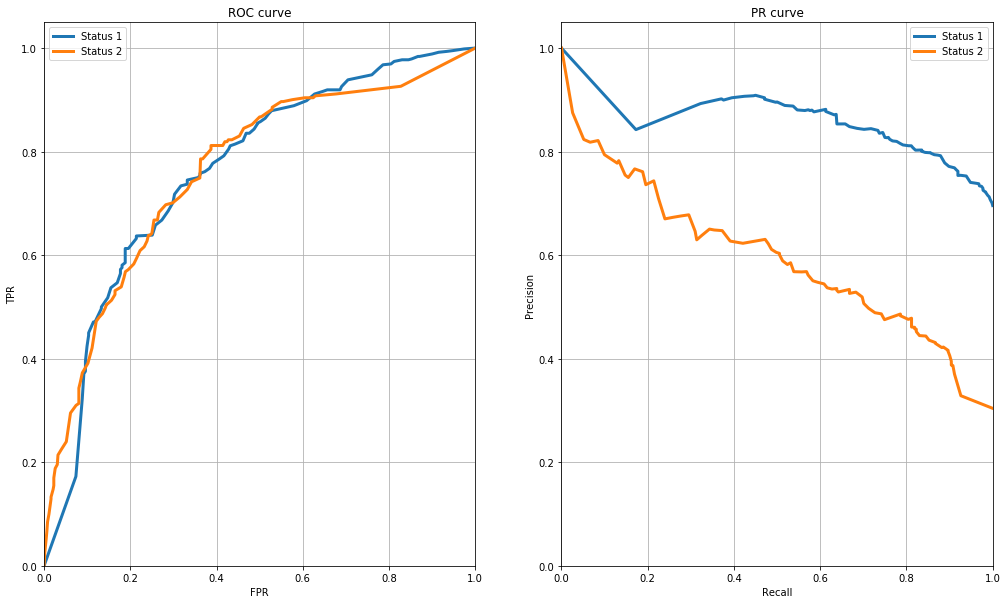

In [26]:
def plot_roc_curve(y_test, y_probs, class_label):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,class_label-1], pos_label=class_label)
    plot_curve_xy(fpr, tpr, class_label)

def plot_pr_curve(y_test, y_probs, class_label):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:,class_label-1], pos_label=class_label)
    plot_curve_xy(recall, precision, class_label)
    
plt.figure(figsize=(17, 10))

plot_curve(121, plot_roc_curve, y_test, y_tree_probs, 'ROC curve', 'FPR', 'TPR')
plot_curve(122, plot_pr_curve, y_test, y_tree_probs, 'PR curve', 'Recall', 'Precision')

plt.show();

## 3. _Quality assessment_

Как можно видеть по метрикам, модель хорошо предсказывает объекты _большего_ класса _Status(**1**)_, что, наверное, не удивительно, в силу их количественного преобладания.

С _меньшим_ классом _Status(**2**)_ дела обстоят похуже, но, в то же вермя, точность (precision) превышает 50%, что, наверное, приемлемо.

В любом случае, точность предсказаний модели выше, чем если бы мы просто относили все объекты к классу _Status(**1**)_.

### _3.1 Comparison with SVM_

_Сравним качаество предсказаний с SVM_.

In [27]:
from sklearn.svm import SVC

In [28]:
%%time

svc = SVC(random_state=51)

svc_grid_params = {
    'C' : [0.1, 0.5, 1.0, 10.],
    'kernel' : ['linear', 'rbf']
}

gs_svc = GridSearchCV(svc, svc_grid_params, scoring=f1_scorer, cv=5)
gs_svc.fit(X_norm_train, y_train)

best_svc = gs_svc.best_estimator_

Wall time: 38 s


In [29]:
best_svc

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=51, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
y_svc_pred = best_svc.predict(X_norm_test)

In [31]:
print_scores('SVC', gs_svc.best_score_, y_test, y_svc_pred)

[SVC] F1 score best (train): 0.47332
[SVC] F1 score for best (test): 0.48970

             precision    recall  f1-score   support

          1       0.77      0.90      0.83       620
          2       0.64      0.39      0.49       271

avg / total       0.73      0.75      0.73       891

************************************************************

[SVC] accuracy (test): 0.74972
****************************************

[SVC] R2 (test): -0.18256
****************************************


_Если судить по метрикам качества, то DecisionTree и SVC показывают примерно одинаковую точность предсказаний на данном датасете_.

## 4. _Max depth and overfitting_
Код построения **validation curve** я позаимствовал в [примере sklearn](https://scikit-learn.org/stable/modules/learning_curve.html).

In [32]:
from sklearn.model_selection import validation_curve

In [33]:
best_tree_params

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 40,
 'splitter': 'best'}

### *4.1 max\_depth* 

Будем менять параметр `max_depth`, остальным параметрам присвоим значения, равные найденным нами ранее для оптимального по **f1** дерева. При этом `None` будет последним элементом.

In [34]:
max_depth_range = list(range(3, 16)) + [None]
max_depth_plot_range = list(range(3, 17))

max_depth_tree = DecisionTreeClassifier(**best_tree_params)

train_scores, test_scores = validation_curve(
    max_depth_tree, X, y, param_name='max_depth', param_range=max_depth_range,
    cv=5, scoring=f1_scorer, n_jobs=4)

In [35]:
len(max_depth_range), len(max_depth_plot_range)

(14, 14)

In [36]:
def plot_validation_curve(param_range, train_scores, test_scores, xlabel, ylabel):
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(17, 10))

    plt.title("Validation Curve with DecisionTreeClassifier")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0.0, 1.1)
    lw = 2

    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

    plt.legend(loc="best")
    plt.grid()
    plt.show()

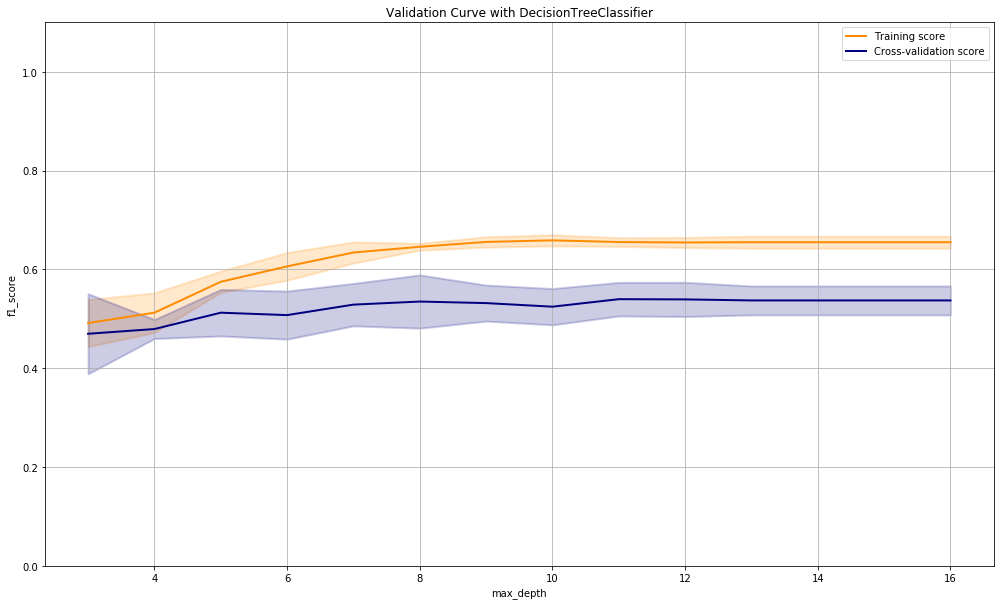

In [37]:
plot_validation_curve(max_depth_plot_range, train_scores, test_scores, 'max_depth', 'f1_score')

Как можно видеть, с какого-то момента (`max_depth`$\approx$`11`) дальнейшее увеличене глубины дерева не влияет на качество предсказаний.

Но, по-моему, зедсь не наблюдается переобучения, хотя **score** для **train** стабильно более высокий, чем для **test** (или это и есть переобучение?).

### *4.2 min_samples_split* 

Теперь аналогичным образом посмотрим на `min_samples_split`.

In [38]:
min_samples_split_range = list(range(3, 500, 5))
min_samples_split_tree = DecisionTreeClassifier(**best_tree_params)

train_scores, test_scores = validation_curve(
    min_samples_split_tree, X, y, param_name='min_samples_split', param_range=min_samples_split_range,
    cv=5, scoring=f1_scorer, n_jobs=1)

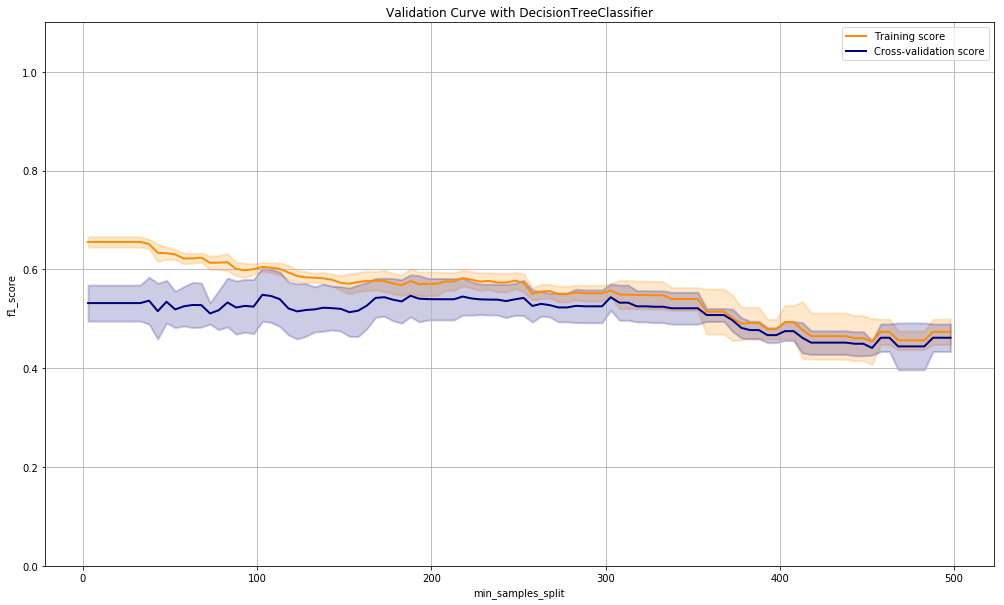

In [39]:
plot_validation_curve(min_samples_split_range, train_scores, test_scores, 'min_samples_split', 'f1_score')

Вроде как можно считать, что при увеличении `min_samples_split` переобучение уменьшается (**score** сходится)? Но точность при этом начинает падать.

## 5. _Visualization_

In [40]:
def plot_real_vs_predicted(X, y_test, y_pred):
    plt.figure(figsize=(17,10))
    
    def subplot(nrc, title, X, y):
        plt.subplot(nrc)
        plt.title(title)
        for u in sorted(np.unique(y)):
            ix = np.argwhere(y == u).squeeze()
            plt.scatter(X[ix, 0], X[ix, 1], label='Status {}'.format(u))
        plt.legend(loc=4)
        
    subplot(121, 'Real', X, y_test)
    subplot(122, 'Predicted', X, y_pred)

### _5.1 Decision Tree_

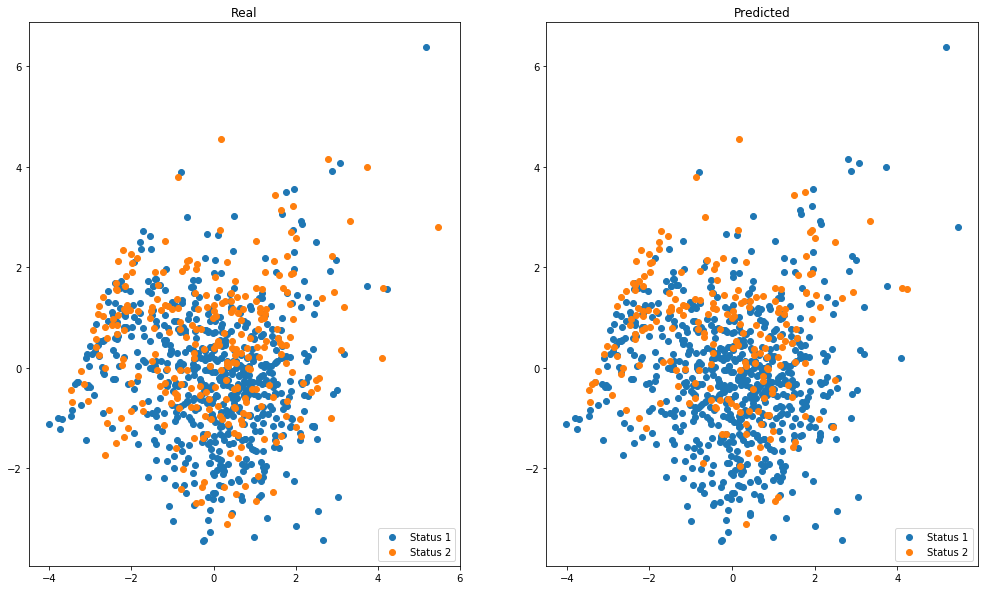

In [41]:
plot_real_vs_predicted(X_pca_test, y_test, y_tree_pred);

### _5.2 SVC_ 

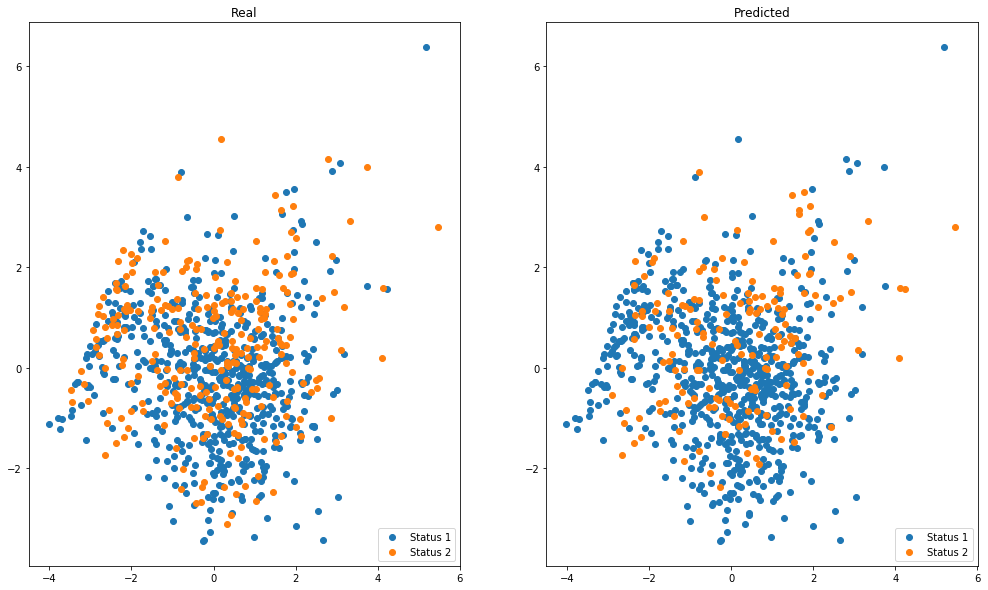

In [42]:
plot_real_vs_predicted(X_pca_test, y_test, y_svc_pred);

_Как можно видеть, графики подтверждают оценки качества, данные выше в пп. 2 и 3: обе модели хуже справлются с предсказанием класса (**2**)_.


## 6. _graphviz_

In [43]:
from sklearn.tree import export_graphviz

In [44]:
export_graphviz(best_tree, out_file='tree.dot', filled=True, feature_names=X.columns)

### _6.1 Пример дерева_

In [45]:
from IPython.display import HTML
from IPython.display import display
display(HTML(filename='tree.html'));

[tree.html](tree.html)

### _6.2 Информационный прирост_
Кажется, необходимую информацию можно [достать из самого дерева](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py), но, чтобы не усложнять, просто вручную подставлю числа из примера получившегося дерева выше.

In [46]:
def information_gain(S0, N, Si, Ni):
    assert N == sum(Ni)
    return S0 - sum(np.array(Si)*np.array(Ni)/N)

In [47]:
# (1) root
'{:.3f}'.format( information_gain(0.4, 3563, [0.343, 0.496], [2948, 615]) )

'0.031'

In [48]:
# (2) left node
'{:.3f}'.format( information_gain(0.343, 2948, [0.47, 0.237], [1004, 1944]) )

'0.027'

In [49]:
# (3) Right node
'{:.3f}'.format( information_gain(0.496, 615, [0.409, 0.481], [283, 332]) )

'0.048'